In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom_v4 import Mushroom

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packag

In [5]:
# !pip install vector-quantize-pytorch

In [6]:
import mushroom.utils as utils

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [8]:
mushroom_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': .001,
        'recon_scaler': 1.,
        'encoder_dim': 256,
        'decoder_dim': 256,
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 32,
        'num_workers': 1,
        'device': 'cuda:2',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 1000,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [9]:
# for config_fp in config_fps:
#     config = yaml.safe_load(open(config_fp))
#     case = config_fp.split('/')[-2]
#     print(case)
    
#     out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/outputs')
#     chkpt_dir = os.path.join(out_dir, 'chkpts')
#     Path(chkpt_dir).mkdir(parents=True, exist_ok=True)
    
#     mushroom_config['sections'] = config
#     mushroom_config['train_kwargs']['save_dir'] = chkpt_dir
    
#     mushroom = Mushroom.from_config(mushroom_config)
    
#     mushroom.train()
#     mushroom.chkpt_filepath = ''
#     mushroom.embed_sections()
#     mushroom.cluster_sections(margin=.05)

#     mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))
#     mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))
    
# #     break
    
    

In [10]:
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'
config = yaml.safe_load(open(config_fp))
case = config_fp.split('/')[-2]

out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_vae_vq/outputs')
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [11]:
mushroom_config['sections'] = config
mushroom_config['train_kwargs']['save_dir'] = chkpt_dir

In [12]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda:2
INFO:root:generating inputs for visium tissue sections
INFO:root:using 13417 channels
INFO:root:5 sections detected: ['s0', 's1', 's2', 's3', 's4']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [13]:
# %%time
# b = next(iter(mushroom.learner.train_dl))

In [14]:
# device = mushroom.learner.device
# img_x = torch.stack((b['anchor_img'], b['pos_img'], b['neg_img']))
# section_x = torch.stack((b['anchor_idx'], b['pos_idx'], b['neg_idx']))
# img_x, section_x = img_x.to(device), section_x.to(device)

# losses, outputs = mushroom.learner.sae(img_x, section_x)

In [15]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(0.7233, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6573, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.9540, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1_vae_vq/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(0.7055, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6753, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(30.1614, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 30: {'overall_loss': tensor(0.5805, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5678, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.6786, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 40: {'overall_loss': tensor(0.4731, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4586, device='cuda:2', gra

INFO:root:iteration 350: {'overall_loss': tensor(0.4285, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4161, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.3853, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 360: {'overall_loss': tensor(0.4701, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4542, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(15.8476, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 370: {'overall_loss': tensor(0.4034, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3903, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.1125, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 380: {'overall_loss': tensor(0.4420, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4286, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.4070, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 390:

INFO:root:iteration 690: {'overall_loss': tensor(0.4377, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4245, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.2638, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 700: {'overall_loss': tensor(0.4160, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4042, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.7292, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 710: {'overall_loss': tensor(0.4187, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4051, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.6356, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 720: {'overall_loss': tensor(0.4253, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4119, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.3862, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 730:

INFO:root:iteration 1030: {'overall_loss': tensor(0.3900, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3780, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0219, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1040: {'overall_loss': tensor(0.4451, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4330, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0901, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1050: {'overall_loss': tensor(0.4432, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4283, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(14.9265, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1060: {'overall_loss': tensor(0.4221, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4097, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.4428, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 1370: {'overall_loss': tensor(0.4493, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4375, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.8071, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1380: {'overall_loss': tensor(0.4091, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3978, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.3199, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1390: {'overall_loss': tensor(0.4507, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4386, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0334, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1400: {'overall_loss': tensor(0.4203, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4080, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.3260, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 1710: {'overall_loss': tensor(0.4534, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4400, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.3649, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1720: {'overall_loss': tensor(0.4622, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4487, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.4879, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1730: {'overall_loss': tensor(0.4201, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4080, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0930, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 1740: {'overall_loss': tensor(0.4302, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4181, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0424, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2040: {'overall_loss': tensor(0.4272, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4154, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.7999, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2050: {'overall_loss': tensor(0.4565, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4431, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.3913, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2060: {'overall_loss': tensor(0.4317, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4202, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.5144, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2070: {'overall_loss': tensor(0.4044, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3931, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.2541, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2380: {'overall_loss': tensor(0.4451, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4325, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.5898, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2390: {'overall_loss': tensor(0.3904, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3795, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.8860, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2400: {'overall_loss': tensor(0.3914, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3804, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.0342, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2410: {'overall_loss': tensor(0.4290, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4154, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.5440, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2720: {'overall_loss': tensor(0.3977, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3869, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.8157, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2730: {'overall_loss': tensor(0.4399, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4270, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.8995, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2740: {'overall_loss': tensor(0.4590, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4463, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.7549, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 2750: {'overall_loss': tensor(0.4570, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4447, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.3066, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3050: {'overall_loss': tensor(0.4372, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4245, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.6998, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3060: {'overall_loss': tensor(0.4323, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4201, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.1540, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3070: {'overall_loss': tensor(0.5039, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4877, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(16.2394, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3080: {'overall_loss': tensor(0.4065, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3953, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.2147, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3390: {'overall_loss': tensor(0.4355, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4235, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0056, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3400: {'overall_loss': tensor(0.4363, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4229, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.3565, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3410: {'overall_loss': tensor(0.4411, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4294, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.6753, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3420: {'overall_loss': tensor(0.4881, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4747, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.3307, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3730: {'overall_loss': tensor(0.3790, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3667, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.2681, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3740: {'overall_loss': tensor(0.4219, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4099, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.9934, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3750: {'overall_loss': tensor(0.4641, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4519, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.1568, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 3760: {'overall_loss': tensor(0.4922, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4770, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(15.2182, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 4060: {'overall_loss': tensor(0.4056, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3946, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.0823, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4070: {'overall_loss': tensor(0.4746, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4610, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.5854, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4080: {'overall_loss': tensor(0.3936, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3820, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.6109, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4090: {'overall_loss': tensor(0.3901, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3784, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.6961, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 4400: {'overall_loss': tensor(0.4696, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4576, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.9739, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4410: {'overall_loss': tensor(0.4237, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4127, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.9541, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4420: {'overall_loss': tensor(0.4522, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4398, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.4360, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4430: {'overall_loss': tensor(0.4069, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3964, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.4789, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 4740: {'overall_loss': tensor(0.4027, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3911, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.5749, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4750: {'overall_loss': tensor(0.4034, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3919, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.5592, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4760: {'overall_loss': tensor(0.4479, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4360, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.9406, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 4770: {'overall_loss': tensor(0.4246, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4127, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.9810, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 5070: {'overall_loss': tensor(0.4301, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4197, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.3188, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5080: {'overall_loss': tensor(0.4351, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4231, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.9870, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5090: {'overall_loss': tensor(0.4208, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4109, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(9.9684, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5100: {'overall_loss': tensor(0.4507, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4382, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.5152, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5

INFO:root:iteration 5410: {'overall_loss': tensor(0.4428, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4328, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.0737, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5420: {'overall_loss': tensor(0.4464, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4345, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.8815, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5430: {'overall_loss': tensor(0.4183, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4075, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.8260, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5440: {'overall_loss': tensor(0.4429, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4327, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.2153, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 5750: {'overall_loss': tensor(0.4102, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3998, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.3672, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5760: {'overall_loss': tensor(0.4772, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4658, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.4607, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5770: {'overall_loss': tensor(0.3987, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3894, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(9.3666, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5780: {'overall_loss': tensor(0.4692, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4576, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.5339, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 5

INFO:root:iteration 6080: {'overall_loss': tensor(0.4213, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4114, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(9.9423, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6090: {'overall_loss': tensor(0.4341, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4222, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.8473, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6100: {'overall_loss': tensor(0.3846, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3745, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.0381, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6110: {'overall_loss': tensor(0.4453, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4348, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.5212, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6

INFO:root:iteration 6420: {'overall_loss': tensor(0.3944, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3836, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.8512, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6430: {'overall_loss': tensor(0.4435, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4324, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.1932, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6440: {'overall_loss': tensor(0.4169, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4057, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.1101, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6450: {'overall_loss': tensor(0.4658, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4526, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.2281, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 6760: {'overall_loss': tensor(0.4175, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4081, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(9.4206, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6770: {'overall_loss': tensor(0.4432, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4311, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0662, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6780: {'overall_loss': tensor(0.3843, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3742, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.1109, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6790: {'overall_loss': tensor(0.4499, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4375, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.3672, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 6

INFO:root:iteration 7090: {'overall_loss': tensor(0.4358, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4234, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.3277, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7100: {'overall_loss': tensor(0.4093, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3983, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.0175, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7110: {'overall_loss': tensor(0.3966, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3858, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.7719, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7120: {'overall_loss': tensor(0.4342, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4228, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.3737, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 7430: {'overall_loss': tensor(0.4501, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4380, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.1721, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7440: {'overall_loss': tensor(0.4113, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4002, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.0716, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7450: {'overall_loss': tensor(0.4667, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4536, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.1010, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7460: {'overall_loss': tensor(0.4190, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4090, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.0224, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 7770: {'overall_loss': tensor(0.4146, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4037, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.8862, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7780: {'overall_loss': tensor(0.4641, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4517, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.3391, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7790: {'overall_loss': tensor(0.4419, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4311, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.8913, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 7800: {'overall_loss': tensor(0.4239, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4119, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.0616, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 8100: {'overall_loss': tensor(0.4199, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4095, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.4052, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8110: {'overall_loss': tensor(0.4570, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4442, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.8260, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8120: {'overall_loss': tensor(0.4376, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4256, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.9742, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8130: {'overall_loss': tensor(0.4207, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4098, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.8893, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 8440: {'overall_loss': tensor(0.3885, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3785, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.0830, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8450: {'overall_loss': tensor(0.4156, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4048, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.7643, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8460: {'overall_loss': tensor(0.4351, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4241, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.9946, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8470: {'overall_loss': tensor(0.4317, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4201, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.5932, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 8780: {'overall_loss': tensor(0.4474, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4351, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.2697, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8790: {'overall_loss': tensor(0.3975, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3876, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(9.9087, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8800: {'overall_loss': tensor(0.4043, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3933, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.0022, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8810: {'overall_loss': tensor(0.4186, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4072, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.3749, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 8

INFO:root:iteration 9110: {'overall_loss': tensor(0.4466, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4353, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.3033, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9120: {'overall_loss': tensor(0.3628, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3530, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(9.8124, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9130: {'overall_loss': tensor(0.4741, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4612, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.9371, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9140: {'overall_loss': tensor(0.4486, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4357, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.9633, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9

INFO:root:iteration 9450: {'overall_loss': tensor(0.4352, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4236, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.6012, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9460: {'overall_loss': tensor(0.4316, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4191, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.4635, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9470: {'overall_loss': tensor(0.4805, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4666, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(13.8821, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9480: {'overall_loss': tensor(0.3971, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3861, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.9329, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 9790: {'overall_loss': tensor(0.3874, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3768, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.6533, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9800: {'overall_loss': tensor(0.4433, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4318, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.4881, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9810: {'overall_loss': tensor(0.3846, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3743, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.3205, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 9820: {'overall_loss': tensor(0.4242, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4138, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.3929, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:iteration 

In [16]:
mushroom.embed_sections()

In [17]:
mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))

In [18]:
mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [25]:
os.path.join(out_dir, 'outputs.pt')

'/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt'

In [27]:
d = torch.load('/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt')
d.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [28]:
d['recon_embs']

tensor([[[[ 2.3089e-01,  2.5042e-01,  4.0160e-02,  ...,  2.5042e-01,
            4.0160e-02,  3.1269e-01],
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          ...,
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          [ 1.6370e-01, -1.5678e-02,  2.3870e-01,  ..., -1.5678e-02,
            2.3870e-01,  2.3675e-01]],

         [[-1.2238e-03,  2.2336e-02,  1.0044e-02,  ...,  2.2336e-02,
            1.0044e-02, -1.7283e-02],
          [ 4.2599e-02,  2.7280e-02,  9.8601e-02,  ...,  2.7280e-02,
            9.8601e-02,  1.3791e-02],
          [-3.0337e-02,  1.7819e-02,  7.7605e-02,  ...,  1.7819e-02,
            7.7605e-02,  9.4206e-02],
          ...,
     

In [14]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/chkpts/500iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [22]:
mushroom.chkpt_filepath = ''
mushroom.cluster_kwargs['centroids'] = None

In [19]:
mushroom.embed_sections()

In [19]:
# mushroom.recon_embs_prequant.shape

In [19]:
from einops import rearrange
dists = torch.cdist(rearrange(mushroom.recon_embs_prequant, 'n d h w -> n h w d'),
                    mushroom.learner.sae.vq.codebook.clone().cpu()).detach().numpy()
dists.shape

(5, 60, 60, 100)

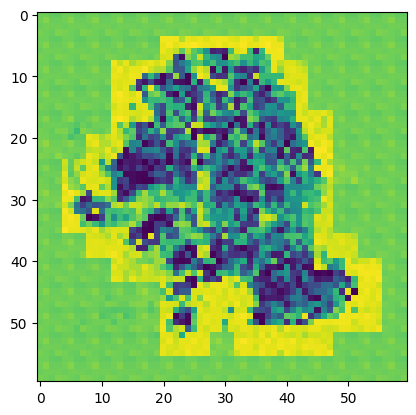

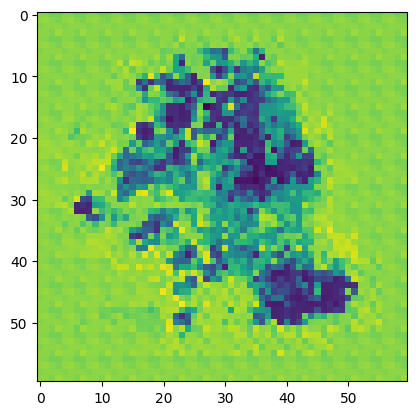

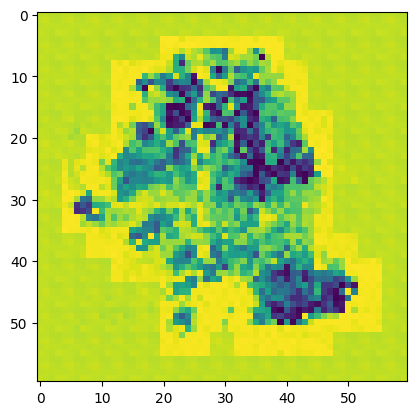

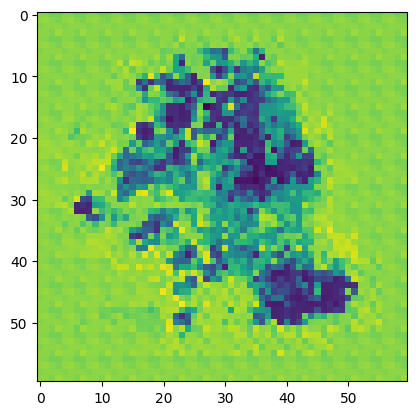

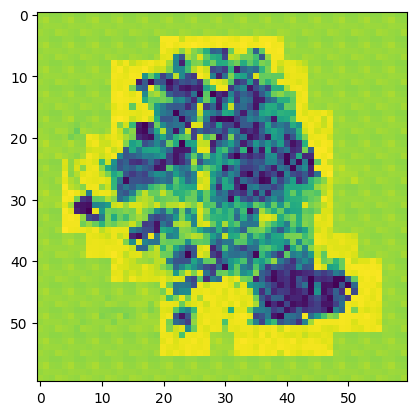

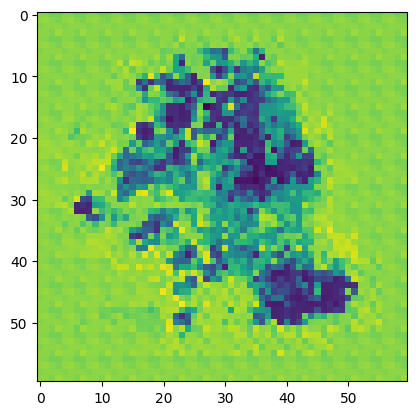

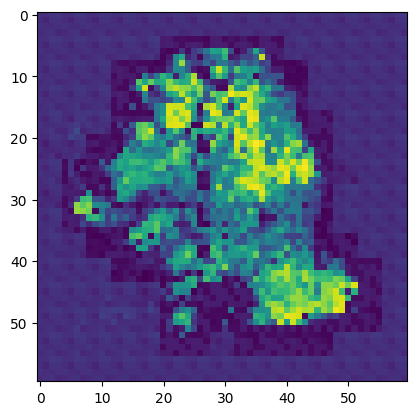

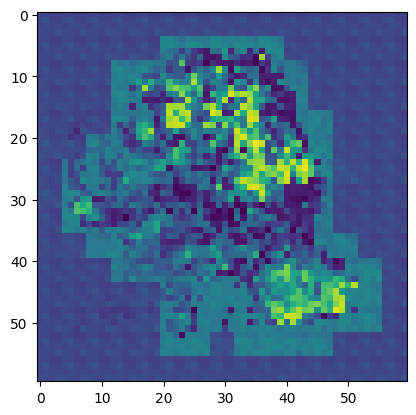

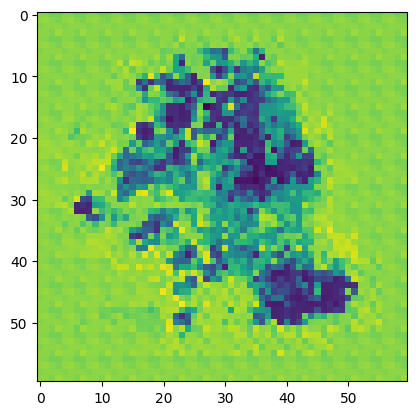

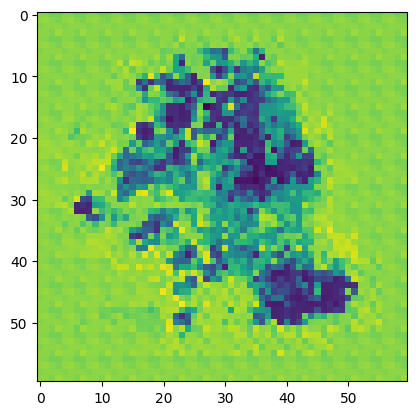

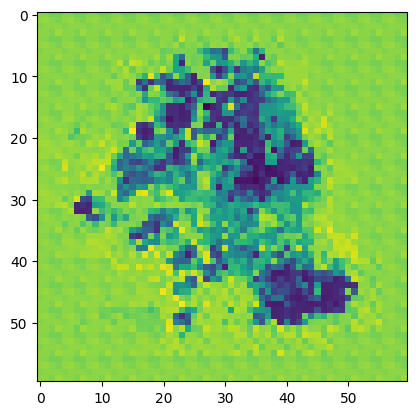

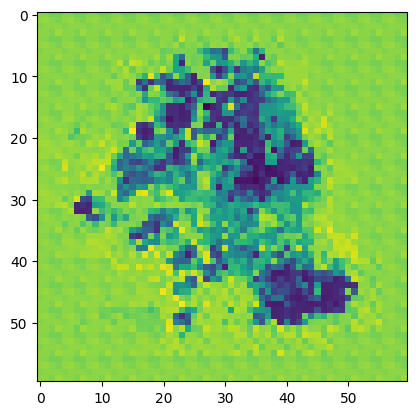

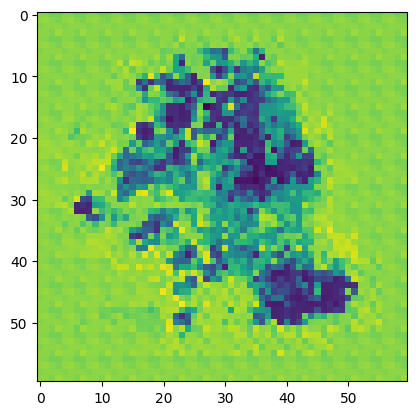

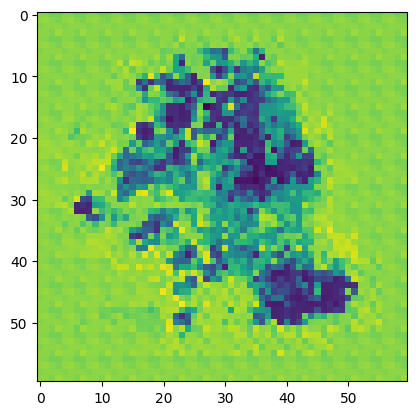

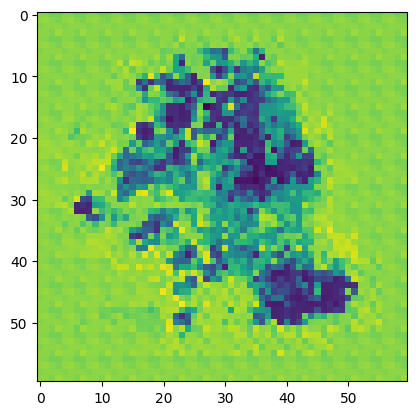

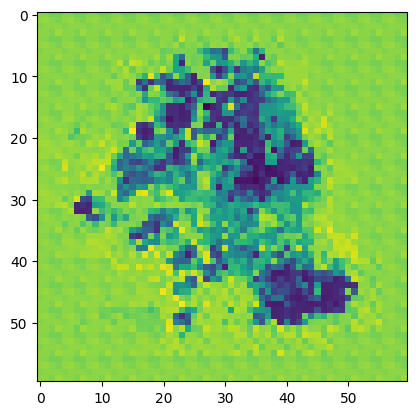

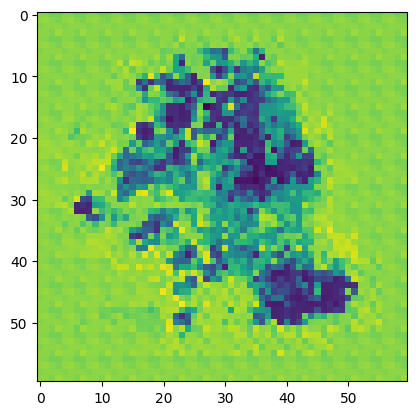

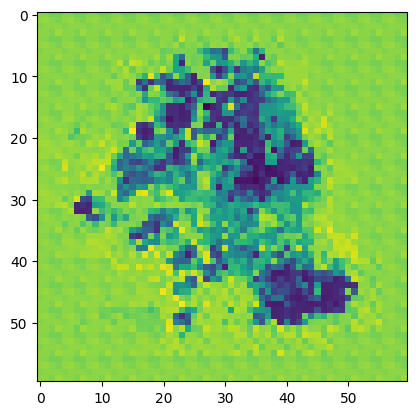

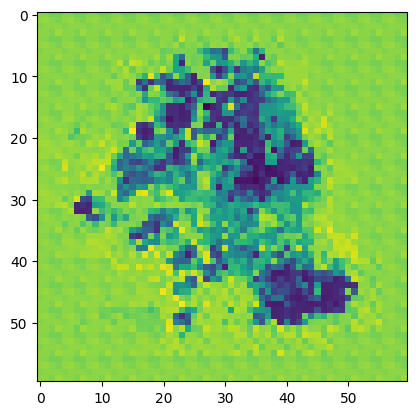

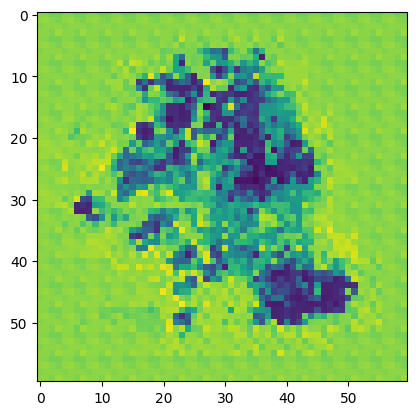

In [20]:
for i in range(20):
    plt.imshow(dists[0, :, :, i])
    plt.show()

In [21]:
# yaml.safe_dump(mushroom_config, open(os.path.join(out_dir, 'mushroom_config.yaml'), 'w'))

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>, <Axes: title={'center': 's2'}>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

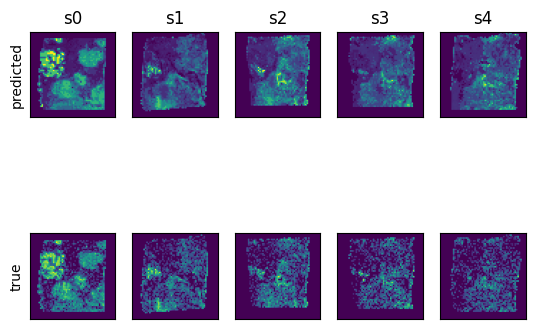

In [20]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>, <Axes: title={'center': 's2'}>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

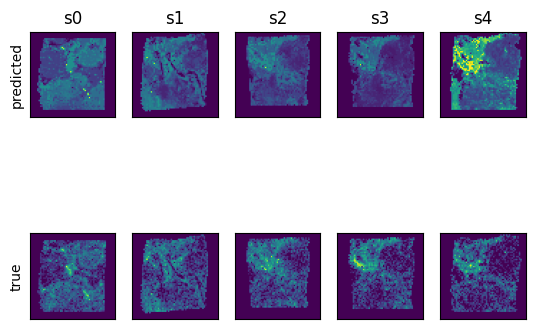

In [21]:
mushroom.display_predicted_pixels(channel='ACTA2')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>, <Axes: title={'center': 's2'}>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

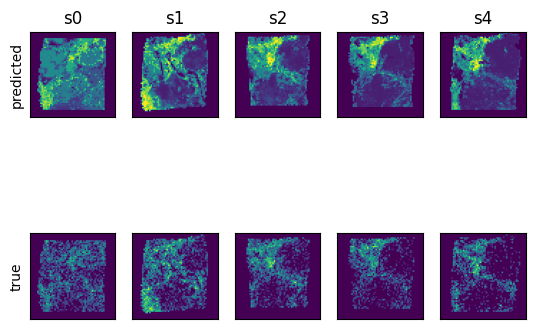

In [22]:
mushroom.display_predicted_pixels(channel='CD68')

In [29]:
mushroom.cluster_sections(margin=.1)

INFO:root:no background channel detected, defaulting to mean of all channels


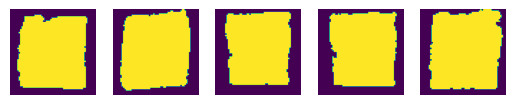

In [30]:
mushroom.clusterer.display_section_masks()

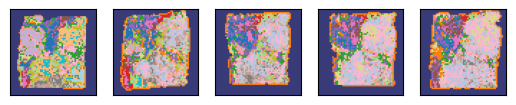

In [31]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

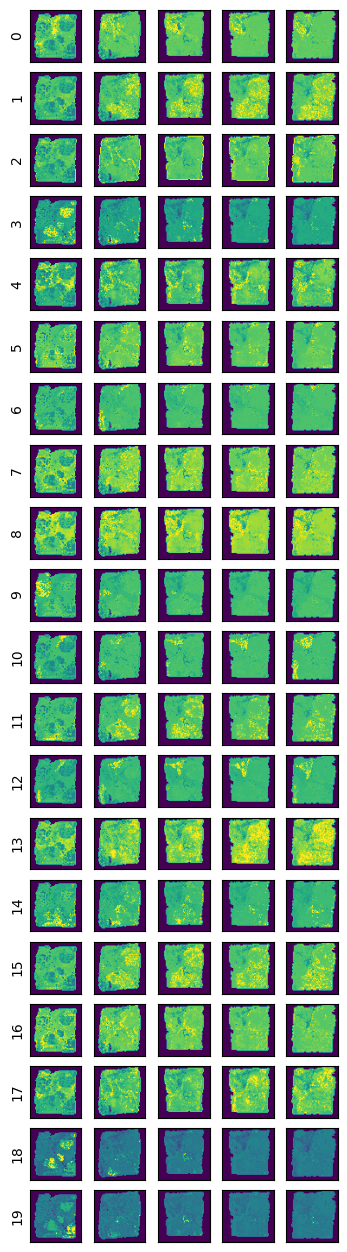

In [32]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

In [53]:
embs = mushroom.recon_embs.clone().detach().numpy()
embs.shape

(2, 1024, 60, 60)

In [55]:
from einops import rearrange
x = rearrange(embs, 'n d h w -> (n h w) d')
x.shape

(7200, 1024)

In [56]:
from umap import UMAP
u = UMAP(n_components=20)
decomp = u.fit_transform(x)
decomp.shape

(7200, 20)

In [57]:
xx = rearrange(decomp, '(n h w) d -> n d h w', n=2, h=60, w=60)
xx.shape

(2, 20, 60, 60)

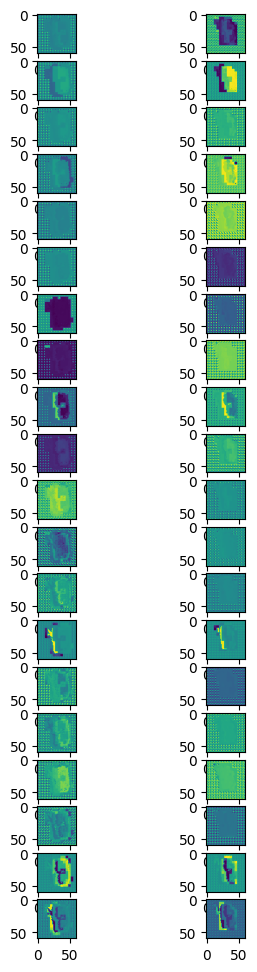

In [61]:
fig, axs = plt.subplots(nrows=xx.shape[1], ncols=xx.shape[0], figsize=(4, 12))
for i in range(xx.shape[1]):
    for j in range(xx.shape[0]):
        ax = axs[i, j]
        ax.imshow(xx[j, i])

In [ ]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/400iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [108]:
config = yaml.safe_load(open(config_fps[-3]))
config = visium_to_ome(config)

s0
s0 0 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff
s3
s3 3 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff


In [109]:
config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath